In [1]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [2]:
import torch

In [3]:
# Node features matrix
x_0 = torch.rand(50, 32)
adj_0 = torch.rand(50,50).round().long()
identity = torch.eye(50)
adj_0 = adj_0 + identity

In [4]:
n_clusters_0 = 50
n_clusters_1 = 5

In [5]:
w_gnn_emb = torch.rand(32, 16)
w_gnn_pool = torch.rand(32, n_clusters_1)

In [6]:
z_0 = torch.relu(adj_0 @ x_0 @ w_gnn_emb)
s_0 = torch.softmax(torch.relu(adj_0 @ x_0 @ w_gnn_pool), dim=1)

In [7]:
x_1 = s_0.t() @ z_0
adj_1 = s_0.t() @ adj_0 @ s_0

In [8]:
print(x_1.shape)
print(adj_1.shape)

torch.Size([5, 16])
torch.Size([5, 5])


In [9]:
import os.path as osp
from math import ceil

import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
import torch_geometric.transforms as T
from torch_geometric.data import DenseDataLoader
from torch_geometric.nn import DenseGCNConv as GCNConv, dense_diff_pool

In [10]:
max_nodes = 150


class MyFilter(object):
    def __call__(self, data):
        return data.num_nodes <= max_nodes


dataset = TUDataset('data', name='PROTEINS', transform=T.ToDense(max_nodes),
                    pre_filter=MyFilter())
dataset = dataset.shuffle()
n = (len(dataset) + 9) // 10
test_dataset = dataset[:n]
val_dataset = dataset[n:2 * n]
train_dataset = dataset[2 * n:]
test_loader = DenseDataLoader(test_dataset, batch_size=32)
val_loader = DenseDataLoader(val_dataset, batch_size=32)
train_loader = DenseDataLoader(train_dataset, batch_size=32)

C:\Users\d\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DenseDataLoader' is deprecated, use 'loader.DenseDataLoader' instead
  warnings.warn(out)


In [11]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 normalize=False, lin=True):
        super(GNN, self).__init__()
        
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        
        self.convs.append(GCNConv(in_channels, hidden_channels, normalize))
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        
        self.convs.append(GCNConv(hidden_channels, hidden_channels, normalize))
        self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        
        self.convs.append(GCNConv(hidden_channels, out_channels, normalize))
        self.bns.append(torch.nn.BatchNorm1d(out_channels))


    def forward(self, x, adj, mask=None):
        batch_size, num_nodes, in_channels = x.size()
        
        for step in range(len(self.convs)):
            x = self.convs[step](x, adj, mask)
            x = x.view(-1, x.size(-1))
            x = self.bns[step](x)
            x = x.view(batch_size, num_nodes, -1)
            x = F.relu(x)

        return x


class DiffPool(torch.nn.Module):
    def __init__(self):
        super(DiffPool, self).__init__()

        num_nodes = ceil(0.25 * max_nodes)
        self.gnn1_pool = GNN(dataset.num_features, 64, num_nodes)
        self.gnn1_embed = GNN(dataset.num_features, 64, 64)

        num_nodes = ceil(0.25 * num_nodes)
        self.gnn2_pool = GNN(64, 64, num_nodes)
        self.gnn2_embed = GNN(64, 64, 64, lin=False)

        self.gnn3_embed = GNN(64, 64, 64, lin=False)

        self.lin1 = torch.nn.Linear(64, 64)
        self.lin2 = torch.nn.Linear(64, dataset.num_classes)

    def forward(self, x, adj, mask=None):
        s = self.gnn1_pool(x, adj, mask)
        x = self.gnn1_embed(x, adj, mask)

        x, adj, l1, e1 = dense_diff_pool(x, adj, s, mask)
        #x_1 = s_0.t() @ z_0
        #adj_1 = s_0.t() @ adj_0 @ s_0
        
        s = self.gnn2_pool(x, adj)
        x = self.gnn2_embed(x, adj)

        x, adj, l2, e2 = dense_diff_pool(x, adj, s)

        x = self.gnn3_embed(x, adj)

        x = x.mean(dim=1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1), l1 + l2, e1 + e2

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPool().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train(epoch):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output, _, _ = model(data.x, data.adj, data.mask)
        loss = F.nll_loss(output, data.y.view(-1))
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0

    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.adj, data.mask)[0].max(dim=1)[1]
        correct += pred.eq(data.y.view(-1)).sum().item()
    return correct / len(loader.dataset)


best_val_acc = test_acc = 0
for epoch in range(50):
    train_loss = train(epoch)
    val_acc = test(val_loader)
    if val_acc > best_val_acc:
        test_acc = test(test_loader)
        best_val_acc = val_acc
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Train Loss: 0.6237, Val Acc: 0.3303, Test Acc: 0.4771
Epoch: 001, Train Loss: 0.5585, Val Acc: 0.7890, Test Acc: 0.6789
Epoch: 002, Train Loss: 0.5302, Val Acc: 0.8073, Test Acc: 0.7064
Epoch: 003, Train Loss: 0.5161, Val Acc: 0.7798, Test Acc: 0.7064
Epoch: 004, Train Loss: 0.5023, Val Acc: 0.7798, Test Acc: 0.7064
Epoch: 005, Train Loss: 0.4857, Val Acc: 0.7890, Test Acc: 0.7064
Epoch: 006, Train Loss: 0.4816, Val Acc: 0.7890, Test Acc: 0.7064
Epoch: 007, Train Loss: 0.4628, Val Acc: 0.7982, Test Acc: 0.7064
Epoch: 008, Train Loss: 0.4477, Val Acc: 0.8165, Test Acc: 0.7248
Epoch: 009, Train Loss: 0.4343, Val Acc: 0.8073, Test Acc: 0.7248
Epoch: 010, Train Loss: 0.4202, Val Acc: 0.8073, Test Acc: 0.7248
Epoch: 011, Train Loss: 0.4154, Val Acc: 0.8073, Test Acc: 0.7248
Epoch: 012, Train Loss: 0.4192, Val Acc: 0.8257, Test Acc: 0.6514
Epoch: 013, Train Loss: 0.4010, Val Acc: 0.8165, Test Acc: 0.6514
Epoch: 014, Train Loss: 0.3658, Val Acc: 0.8073, Test Acc: 0.6514
Epoch: 015

Epoch: 001, Train Loss: 0.1134, Train Acc: 0.7589, Val Loss: 0.9554, Val Acc: 0.7615, Test Loss: 1.1462, Test Acc: 0.7339
Epoch: 002, Train Loss: 0.0805, Train Acc: 0.7359, Val Loss: 1.0197, Val Acc: 0.7798, Test Loss: 1.0942, Test Acc: 0.7615
Epoch: 003, Train Loss: 0.0735, Train Acc: 0.7336, Val Loss: 1.2509, Val Acc: 0.7156, Test Loss: 1.0942, Test Acc: 0.7615
Epoch: 004, Train Loss: 0.0704, Train Acc: 0.7532, Val Loss: 1.1654, Val Acc: 0.7339, Test Loss: 1.0942, Test Acc: 0.7615
Epoch: 005, Train Loss: 0.0598, Train Acc: 0.7243, Val Loss: 1.0605, Val Acc: 0.7339, Test Loss: 1.0942, Test Acc: 0.7615
Epoch: 006, Train Loss: 0.0546, Train Acc: 0.7347, Val Loss: 0.9218, Val Acc: 0.7615, Test Loss: 1.0942, Test Acc: 0.7615
Epoch: 007, Train Loss: 0.0787, Train Acc: 0.6990, Val Loss: 1.2678, Val Acc: 0.7615, Test Loss: 1.0942, Test Acc: 0.7615
Epoch: 008, Train Loss: 0.1301, Train Acc: 0.7405, Val Loss: 1.1128, Val Acc: 0.8073, Test Loss: 1.5146, Test Acc: 0.7248
Epoch: 009, Train Loss: 

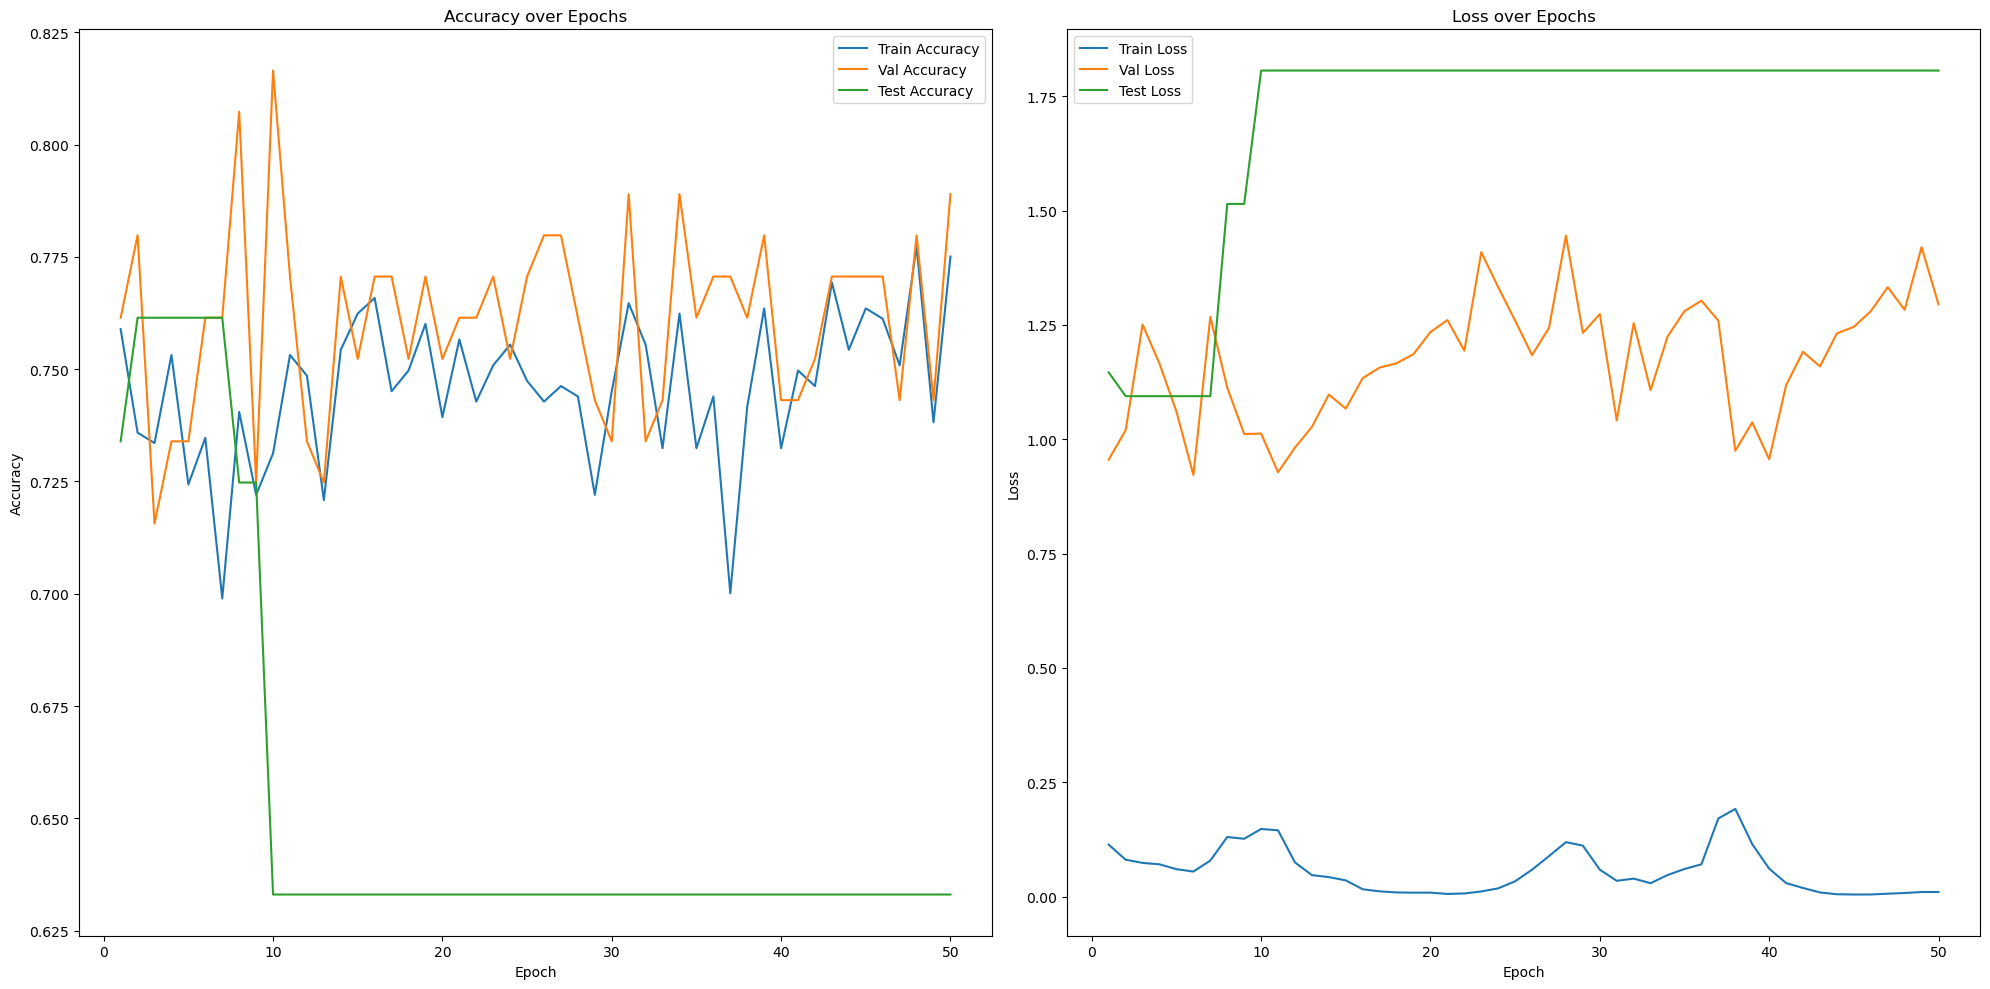

In [13]:
import matplotlib.pyplot as plt

train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []

@torch.no_grad()
def test(loader, return_loss=False):
    model.eval()
    correct = 0
    total_loss = 0
    
    for data in loader:
        data = data.to(device)
        output, _, _ = model(data.x, data.adj, data.mask)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y.view(-1)).sum().item()
        total_loss += F.nll_loss(output, data.y.view(-1)).item() * data.y.size(0)  # Batch Loss 계산
    
    accuracy = correct / len(loader.dataset)
    loss = total_loss / len(loader.dataset)
    
    return (accuracy, loss) if return_loss else accuracy

best_val_acc = test_acc = 0
for epoch in range(1, 51):
    train_loss = train(epoch)
    train_acc, _ = test(train_loader, return_loss=True)  # Train accuracy 측정
    val_acc, val_loss = test(val_loader, return_loss=True)
    
    # 최고 validation accuracy 업데이트 시 test accuracy & loss 갱신
    if val_acc > best_val_acc:
        test_acc, test_loss = test(test_loader, return_loss=True)
        best_val_acc = val_acc
    
    # 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(range(1, 51), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 51), val_accuracies, label='Val Accuracy')
plt.plot(range(1, 51), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 51), train_losses, label='Train Loss')
plt.plot(range(1, 51), val_losses, label='Val Loss')
plt.plot(range(1, 51), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
import matplotlib.pyplot as plt


train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []


@torch.no_grad()
def test(loader, return_loss=False):
    model.eval()
    correct = 0
    total_loss = 0
    
    for data in loader:
        data = data.to(device)
        output, _, _ = model(data.x, data.adj, data.mask)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y.view(-1)).sum().item()
        total_loss += F.nll_loss(output, data.y.view(-1)).item() * data.y.size(0)  # Batch Loss 계산
    
    accuracy = correct / len(loader.dataset)
    loss = total_loss / len(loader.dataset)
    
    return (accuracy, loss) if return_loss else accuracy


best_val_acc = test_acc = 0
for epoch in range(1, 51):
    train_loss = train(epoch)
    train_acc, _ = test(train_loader, return_loss=True)  # Train accuracy 측정
    val_acc, val_loss = test(val_loader, return_loss=True)
    
    # 최고 validation accuracy 업데이트 시 test accuracy & loss 갱신
    if val_acc > best_val_acc:
        test_acc, test_loss = test(test_loader, return_loss=True)
        best_val_acc = val_acc
    
    # 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Loss: 0.0134, Train Acc: 0.7497, Val Loss: 1.3566, Val Acc: 0.7523, Test Loss: 1.7751, Test Acc: 0.7064
Epoch: 002, Train Loss: 0.0108, Train Acc: 0.7393, Val Loss: 1.3639, Val Acc: 0.7615, Test Loss: 1.8247, Test Acc: 0.7156
Epoch: 003, Train Loss: 0.0051, Train Acc: 0.7612, Val Loss: 1.3621, Val Acc: 0.7431, Test Loss: 1.8247, Test Acc: 0.7156
Epoch: 004, Train Loss: 0.0061, Train Acc: 0.7589, Val Loss: 1.3738, Val Acc: 0.7706, Test Loss: 1.9106, Test Acc: 0.6789
Epoch: 005, Train Loss: 0.0061, Train Acc: 0.7589, Val Loss: 1.3857, Val Acc: 0.7798, Test Loss: 1.9920, Test Acc: 0.6789
Epoch: 006, Train Loss: 0.0041, Train Acc: 0.7543, Val Loss: 1.4481, Val Acc: 0.7523, Test Loss: 1.9920, Test Acc: 0.6789
Epoch: 007, Train Loss: 0.0049, Train Acc: 0.7589, Val Loss: 1.4377, Val Acc: 0.7615, Test Loss: 1.9920, Test Acc: 0.6789
Epoch: 008, Train Loss: 0.0026, Train Acc: 0.7555, Val Loss: 1.4504, Val Acc: 0.7523, Test Loss: 1.9920, Test Acc: 0.6789
Epoch: 009, Train Loss: 

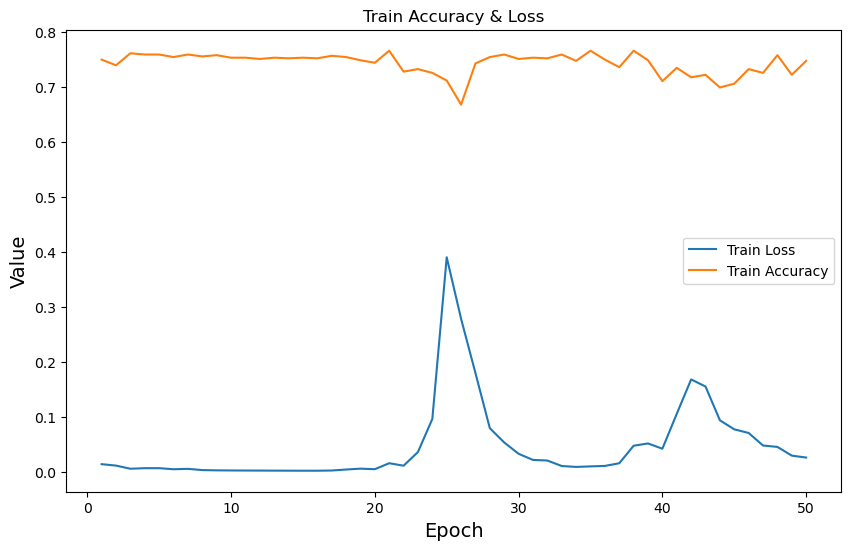

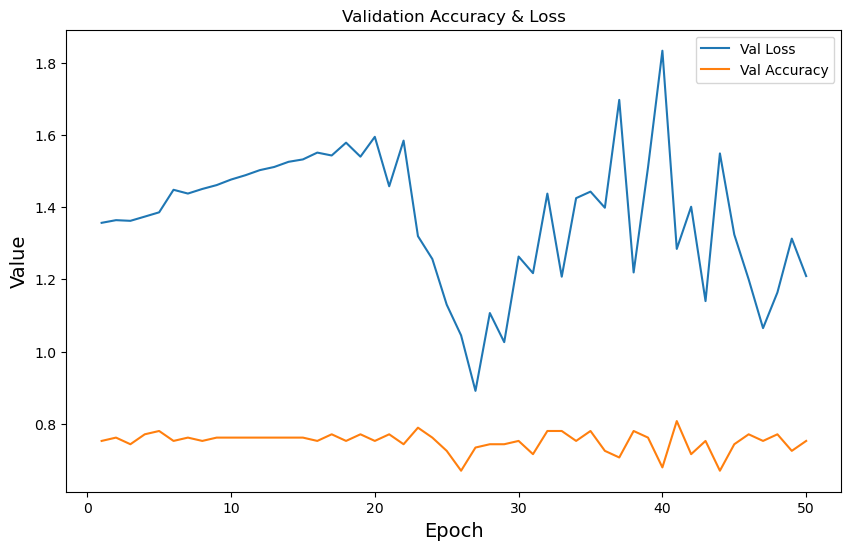

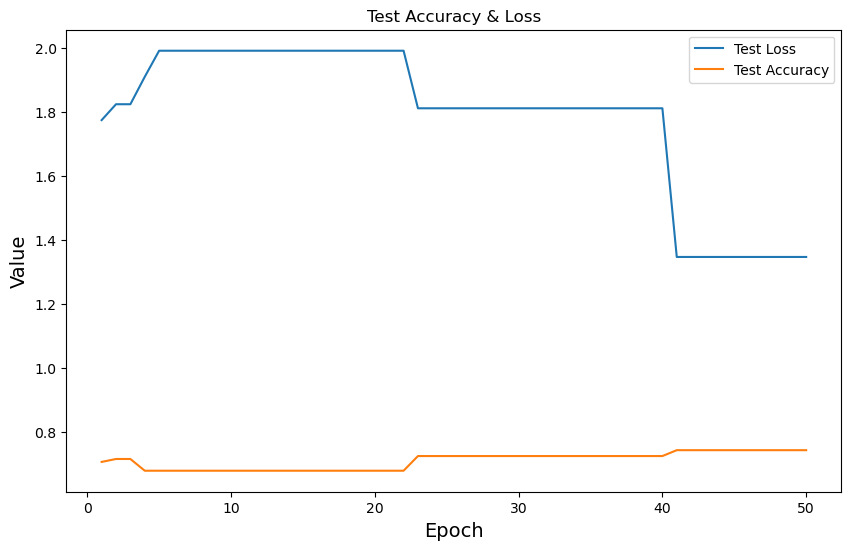

In [15]:
import matplotlib.pyplot as plt

# Train Accuracy & Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), train_losses, label='Train Loss')
plt.plot(range(1, 51), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Train Accuracy & Loss')
plt.legend()
plt.show()

# Validation Accuracy & Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), val_losses, label='Val Loss')
plt.plot(range(1, 51), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Validation Accuracy & Loss')
plt.legend()
plt.show()

# Test Accuracy & Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), test_losses, label='Test Loss')
plt.plot(range(1, 51), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Test Accuracy & Loss')
plt.legend()
plt.show()